In [1]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

- elliptical slice sampler
- metropolis sampler

- birthdays
- mauna loa

- 

# Marginal GP

- data $y$ modeled as the sum of a gp, $f$, and IID Gaussian noise

## Simulate Data

/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


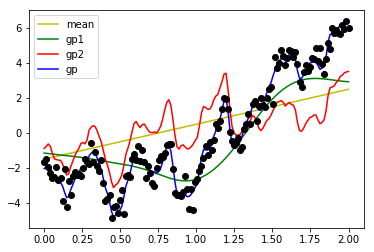

In [2]:
np.random.seed(10)

n = 150
ℓ1_true = 0.3
η1_true = 1.5

ℓ2_true = 0.05
η2_true = 1.0

σ_true = 0.5

X = np.linspace(0, 2, n)[:, None]
Kx1 = (tt.square(η1_true) * pm.gp.cov.ExpQuad(1, ℓ1_true)(X)).eval()
Kx2 = (tt.square(η2_true) * pm.gp.cov.Matern52(1, ℓ2_true)(X)).eval()

# mean func
coeffs_true = 2.0
intercept_true = -1.5
m = pm.gp.mean.Linear(coeffs=coeffs_true, intercept=intercept_true)(X).eval()

# gp1
f1_true = pm.MvNormal.dist(mu=m, cov=Kx1).random(size=1)

# gp2
f2_true = pm.MvNormal.dist(mu=m, cov=Kx2).random(size=1)

#gp
f_true = f1_true + f2_true

noise = pm.Normal.dist(mu=0.0, sd=σ_true).random(size=n)
y = f_true + noise
plt.plot(X, m, "y", label="mean")
plt.plot(X, f1_true, "g", label="gp1");
plt.plot(X, f2_true, "r", label="gp2");
plt.plot(X, f_true, "b", label="gp");
plt.plot(X, y, 'ok');
plt.legend();

## Infer hyperparameters

In [3]:
with pm.Model() as model:
    # gp1, long term trend
    ℓ1 = pm.Gamma("ℓ1", alpha=1, beta=1, testval=0.5)
    η1 = pm.HalfCauchy("η1", beta=3)
    cov1 = tt.square(η1) * pm.gp.cov.ExpQuad(1, ℓ1) 
   
    # gp1 mean function
    coeffs = pm.StudentT("coeffs", mu=0.0, lam=0.1, nu=4)
    intercept = pm.StudentT("intercept", mu=0.0, lam=0.1, nu=4)
    mean = pm.gp.mean.Linear(coeffs, intercept)
    
    # gp1
    gp1 = pm.gp.Marginal(mean_func=mean, cov_func=cov1)
   
    #gp2, shorter variation
    ℓ2 = pm.Gamma("ℓ2", alpha=1, beta=1, testval=0.1)
    η2 = pm.HalfCauchy("η2", beta=3)
    cov2 = tt.square(η2) * pm.gp.cov.Matern52(1, ℓ2)
    gp2 = pm.gp.Marginal(cov_func=cov2)
    
    # additive
    gp = gp1 + gp2
    
    σ = pm.HalfCauchy("σ", beta=3, testval=0.1)
    y_ = gp.prior("y", n_points=n, X=X, y=y, sigma=σ)
    tr = pm.sample(1000)

TypeError: prior() got an unexpected keyword argument 'sigma'

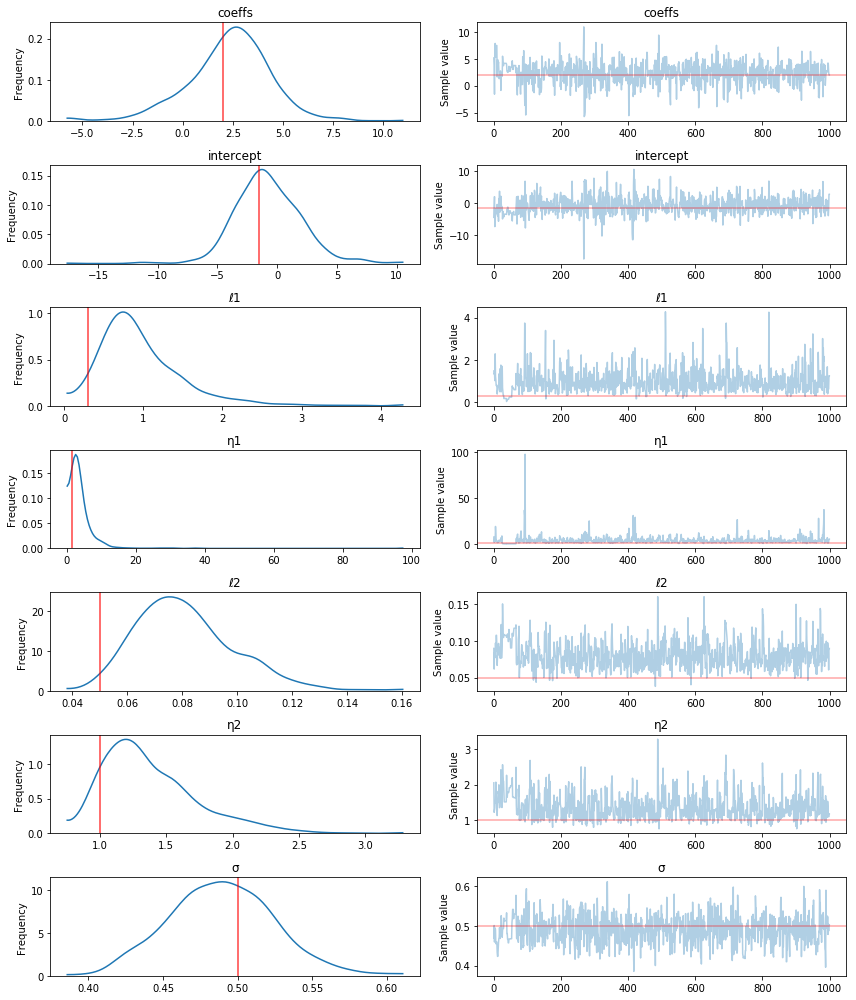

In [4]:
pm.traceplot(tr, lines={"ℓ1": ℓ1_true, "η1": η1_true,
                        "ℓ2": ℓ2_true, "η2": η2_true,
                        "coeffs": coeffs_true, "intercept": intercept_true,
                        "σ": σ_true });

## Predict

In [5]:
ns = 400
Xnew = np.linspace(0.0, 3.0, ns)[:, None]
with model:
    f_pred = gp.conditional("f_pred", n_points=ns, Xnew=Xnew)

In [6]:

with model:
    f1_pred = gp1.conditional("f1_pred", n_points=ns, Xnew=Xnew, X=X, y=y, sigma=σ)
    f2_pred = gp2.conditional("f2_pred", n_points=ns, Xnew=Xnew, X=X, y=y, sigma=σ)

In [7]:
with model:
    samples = pm.sample_ppc(tr, vars=[f_pred, f1_pred, f2_pred], samples=100)

100%|██████████| 100/100 [00:13<00:00,  7.97it/s]


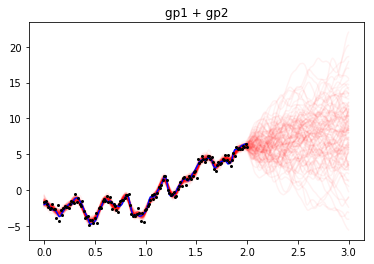

In [8]:
plt.plot(Xnew.flatten(), samples[f_pred.name].T, "r", alpha=0.05);
plt.plot(X, f_true, 'b');
plt.plot(X, y, 'ko', markersize=2);
plt.title("gp1 + gp2");

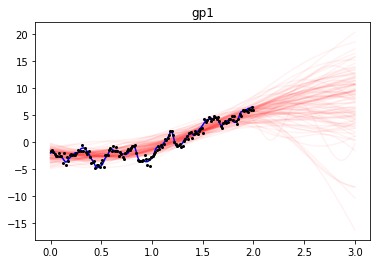

In [9]:
plt.plot(Xnew.flatten(), samples[f1_pred.name].T, "r", alpha=0.05);
plt.plot(X, f_true, 'b');
plt.plot(X, y, 'ko', markersize=2);
plt.title("gp1");

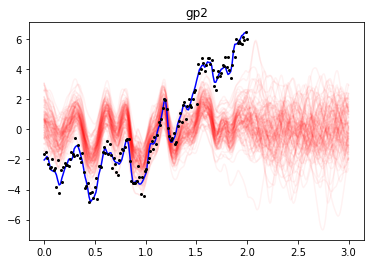

In [10]:
plt.plot(Xnew.flatten(), samples[f2_pred.name].T, "r", alpha=0.05);
plt.plot(X, f_true, 'b');
plt.plot(X, y, 'ko', markersize=2);
plt.title("gp2");

# Latent GP

- model $f$ explicitly
- simulate data as a classification problem

## Simulate Data

/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


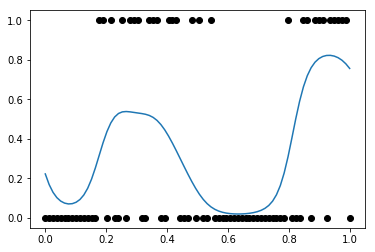

In [11]:
np.random.seed(11)

n = 80
ℓ_true = 0.1
σ_true = 0.2
η_true = 1.5

X = np.linspace(0, 1, n)[:, None]
Kx = (tt.square(η_true) * pm.gp.cov.ExpQuad(1, ℓ_true)(X)).eval()
m = np.zeros(n)

f_true = pm.MvNormal.dist(mu=m, cov=Kx).random(size=1)
p_true = 1.0 / (1.0 + np.exp(-f_true))

y = pm.Bernoulli.dist(p=p_true).random()
plt.plot(X, p_true);
plt.plot(X, y, 'ok');

## Infer hyperparameters

In [12]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1, testval=0.4)
    η = pm.HalfCauchy("η", beta=3)
    cov = tt.square(η) * pm.gp.cov.ExpQuad(1, ℓ) 
    mean = pm.gp.mean.Zero()
    
    gp = pm.gp.Latent(mean_func=mean, cov_func=cov)
    
    f = gp.prior("f", n_points=n, X=X)
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)
    
    tr = pm.sample(200)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 56.812:   6%|▌         | 11038/200000 [00:21<05:48, 541.78it/s]
Convergence archived at 11100
Interrupted at 11,100 [5%]: Average Loss = 66.805
100%|█████████▉| 698/700 [01:09<00:00, 15.14it/s]/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:425: UserWarning: Chain 0 contains only 200 samples.
  % (self._chain_id, n))
100%|██████████| 700/700 [01:09<00:00, 10.07it/s]


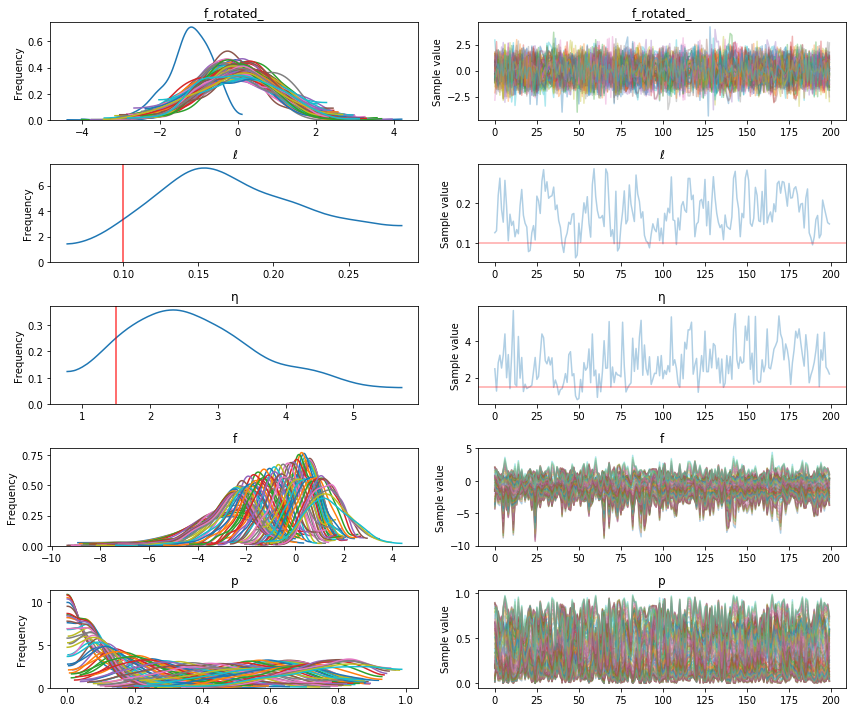

In [13]:
pm.traceplot(tr, lines={"ℓ": ℓ_true, "η": η_true, "σ": σ_true });

## Predict

In [14]:
ns = 200
Xnew = np.linspace(-0.3, 1.3, ns)[:, None]
with model:
    f_pred = gp.conditional("f_pred", ns, Xnew)
    samples = pm.sample_ppc(tr, vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:01<00:00, 90.81it/s]


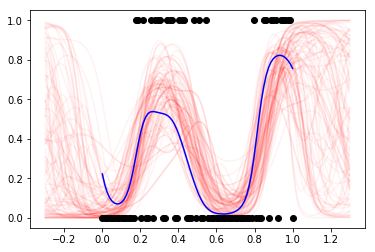

In [15]:
def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps
    
plt.plot(Xnew.flatten(), invlogit(samples[f_pred.name].T), "r", alpha=0.05);
plt.plot(X, p_true, 'b');
plt.plot(X, y, 'ko');

# Marginal GP with sparse approximation

- data $y$ modeled as the sum of a gp, $f$, and IID Gaussian noise
- FITC approximation used with 20 inducing points

## Simulate Data

/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


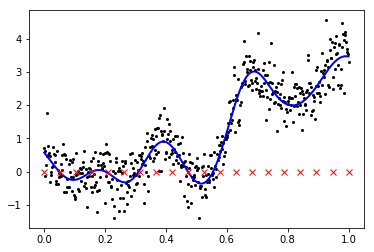

In [16]:
np.random.seed(30)

n = 500
ℓ_true = 0.1
σ_true = 0.5
η_true = 1.5

X = np.linspace(0, 1, n)[:, None]
Kx = (tt.square(η_true) * pm.gp.cov.ExpQuad(1, ℓ_true)(X)).eval()
m = np.zeros(n)

f_true = pm.MvNormal.dist(mu=m, cov=Kx).random(size=1)
noise = pm.Normal.dist(mu=0.0, sd=σ_true).random(size=n)
y = f_true + noise

nu = 20
Xu = np.linspace(0, 1, nu)[:, None]

plt.plot(X, y, 'ok', ms=2);
plt.plot(X, f_true, "blue", lw=2);
plt.plot(Xu, np.zeros(nu), "rx");

## Infer hyperparameters

In [17]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1, testval=0.4)
    η = pm.HalfCauchy("η", beta=3)
    cov = tt.square(η) * pm.gp.cov.ExpQuad(1, ℓ) 
    mean = pm.gp.mean.Zero()
    σ = pm.HalfCauchy("σ", beta=3)
    
    gp = pm.gp.MarginalSparse(cov_func=cov)
    y_ = gp.prior("y", n_points=500, X=X, y=y, Xu=Xu, sigma=σ)
    tr = pm.sample(1000)

TypeError: prior() missing 1 required positional argument: 'condition'

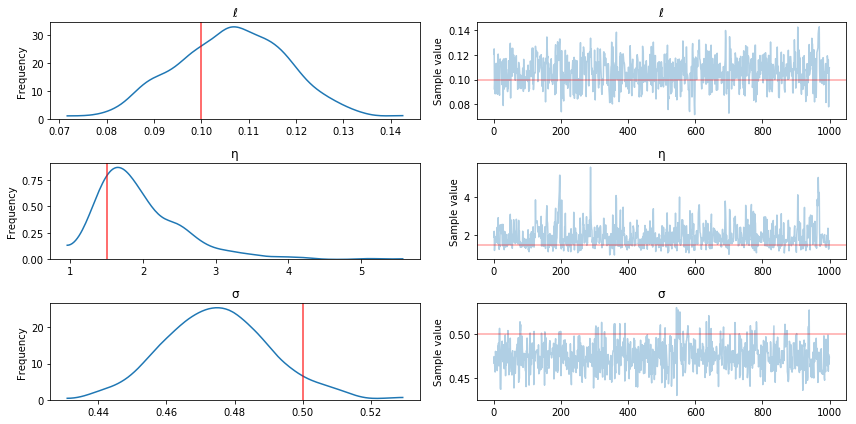

In [17]:
pm.traceplot(tr, lines={"ℓ": ℓ_true, "η": η_true, "σ": σ_true });

## Predict

100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


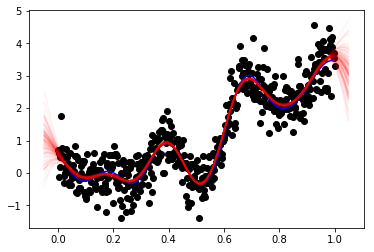

In [18]:
ns = 80
Xs = np.linspace(-0.05, 1.05, ns)[:, None]
with model:
    f_pred = gp("f_pred", ns, mean).conditioned_on(X, Xu=Xu, y=y, Xs=Xs, sigma=σ)

with model:
    samples = pm.sample_ppc(tr, vars=[f_pred], samples=100)

plt.plot(X, y, 'ko');
plt.plot(X, f_true, 'b');
plt.plot(Xs.flatten(), samples[f_pred.name].T, "r", alpha=0.05);